In [1]:
#%%capture

import pandas as pd
import numpy as np
import scipy as sp
import plotly
import folium
import os

import plotly.io as pio
pio.renderers.default='notebook'

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets
from IPython.core.display import HTML
from IPython.display import display, clear_output
import datetime
from io import StringIO


import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import trianer

plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
%reload_ext autoreload
%autoreload 2



- 
- Research in alpha signal to predict market moves

In [2]:
athlete = trianer.Athlete(
        config={
"swimming_sX100m":datetime.time(2, 35),
"cycling_kmXh":30,
"running_sXkm":datetime.time(5, 30),
"transition_swi2cyc_s":datetime.time(2, 0),
"transition_cyc2run_s":datetime.time(2, 0),
"weight_kg":70
})
race = trianer.Race(name="Elsassman (L)")
simulation = trianer.Triathlon(race=race, athlete=athlete)
simulation.show_roadmap()

2022-09-21 18:45:34.289 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            
2022-09-21 18:45:34.293 
  command:

    streamlit run /opt/miniconda/envs/trianer_py3.10/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


{'swimming': [0], 'cycling': [0, 39], 'running': [0, 3.25, 6.75, 10.0, 13.25, 16.75]}


Depuis depart,discipline,distance,Consommation,Boisson,Alimentation,Temps de passage,Bilan hydrique,Bilan kcalorique,Durée totale,Temperature
0.000000,swimming,0 km,transition,100 ml,0 kcal,08:00,100 ml,0 kcal,00:00,15 °C
38.000000,transition 1,2 km,Isotonic+pate de fruits + compote,300 ml,200 kcal,08:38,-473 ml,-58 kcal,00:38,16 °C
68.000000,cycling,15 km,30 min,300 ml,100 kcal,09:08,-676 ml,-556 kcal,01:08,16 °C
98.000000,cycling,26 km,30 min,300 ml,100 kcal,09:38,-911 ml,-1052 kcal,01:38,17 °C
129.000000,cycling,33 km,30 min,300 ml,100 kcal,10:08,-1166 ml,-1547 kcal,02:08,18 °C
142.000000,cycling,39 km,org: remplir eau,300 ml,100 kcal,10:21,-1125 ml,-1704 kcal,02:21,18 °C
172.000000,cycling,59 km,30 min,300 ml,100 kcal,10:51,-1430 ml,-2199 kcal,02:51,19 °C
202.000000,cycling,74 km,30 min,300 ml,100 kcal,11:21,-1782 ml,-2694 kcal,03:21,19 °C
214.000000,transition 2,80 km,Isotonic+pate de fruits + gel,300 ml,200 kcal,11:34,-2062 ml,-2540 kcal,03:34,20 °C
231.000000,running,3 km,org: eau + fruit,300 ml,100 kcal,11:50,-2148 ml,-2688 kcal,03:50,20 °C


In [3]:
simulation.show_roadmap()

Depuis depart,discipline,distance,Consommation,Boisson,Alimentation,Temps de passage,Bilan hydrique,Bilan kcalorique,Durée totale,Temperature
0.000000,swimming,0 km,transition,100 ml,0 kcal,08:00,100 ml,0 kcal,00:00,15 °C
38.000000,transition 1,2 km,Isotonic+pate de fruits + compote,300 ml,200 kcal,08:38,-473 ml,-58 kcal,00:38,16 °C
68.000000,cycling,15 km,30 min,300 ml,100 kcal,09:08,-676 ml,-556 kcal,01:08,16 °C
98.000000,cycling,26 km,30 min,300 ml,100 kcal,09:38,-911 ml,-1052 kcal,01:38,17 °C
129.000000,cycling,33 km,30 min,300 ml,100 kcal,10:08,-1166 ml,-1547 kcal,02:08,18 °C
142.000000,cycling,39 km,org: remplir eau,300 ml,100 kcal,10:21,-1125 ml,-1704 kcal,02:21,18 °C
172.000000,cycling,59 km,30 min,300 ml,100 kcal,10:51,-1430 ml,-2199 kcal,02:51,19 °C
202.000000,cycling,74 km,30 min,300 ml,100 kcal,11:21,-1782 ml,-2694 kcal,03:21,19 °C
214.000000,transition 2,80 km,Isotonic+pate de fruits + gel,300 ml,200 kcal,11:34,-2062 ml,-2540 kcal,03:34,20 °C
231.000000,running,3 km,org: eau + fruit,300 ml,100 kcal,11:50,-2148 ml,-2688 kcal,03:50,20 °C


In [4]:
print(trianer.Race(name="Elsassman (L)").get_key())
print(trianer.Race(name="Ironman").get_key())
print(trianer.Race(name="Triathlon (S)").get_key())
print(trianer.Race(name="Elsassman (L)").get_info())
print(trianer.Race(name="Ironman").get_info())
print(trianer.Race(name="Triathlon (S)").get_info())

swimming:1.9,cycling:80.3:1366,running:20:306
swimming:3.8,cycling:180,running:42.195
swimming:0.65,cycling:20,running:5
Elsassman (L) swimming: 1.9km cycling: 80.3km  (D+=1366m) running: 20km  (D+=306m) 
Ironman swimming: 3.8km cycling: 180km running: 42.195km 
Triathlon (S) swimming: 0.65km cycling: 20km running: 5km 


In [5]:
athlete = trianer.Athlete(
        config={
"swimming_sX100m":datetime.time(2, 35),
"cycling_kmXh":30,
"running_sXkm":datetime.time(5, 30),
"transition_swi2cyc_s":datetime.time(2, 0),
"transition_cyc2run_s":datetime.time(2, 0),
"weight_kg":70
})
race = trianer.Race(name="Elsassman (L)")

simulation = trianer.Triathlon(race=race, athlete=athlete)

{'swimming': [], 'cycling': [], 'running': []}


<AxesSubplot:xlabel='fdistance'>

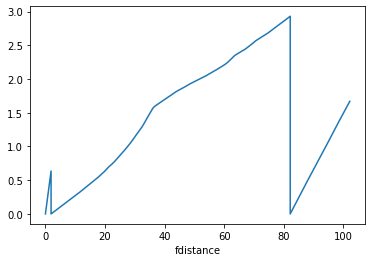

In [6]:
simulation.data.set_index("fdistance")["cduration"].plot()

(-5.1100000000000065, 107.31000000000014) (154.0, 1386.0)


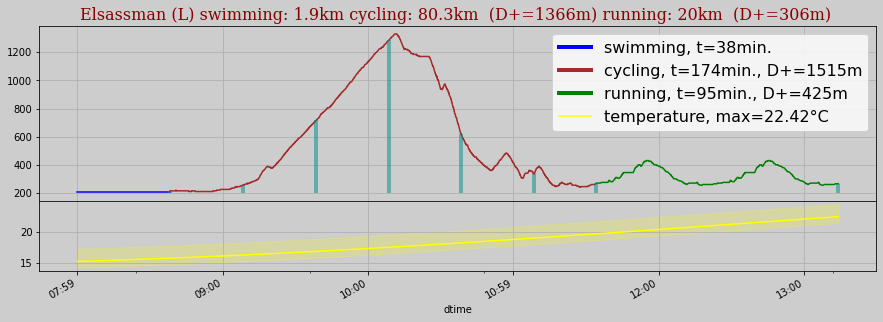

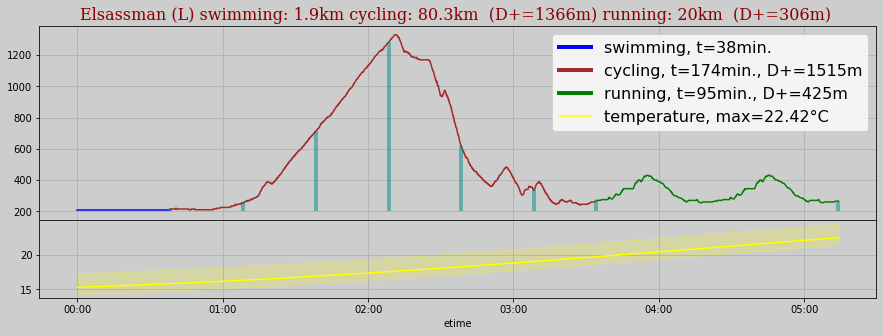

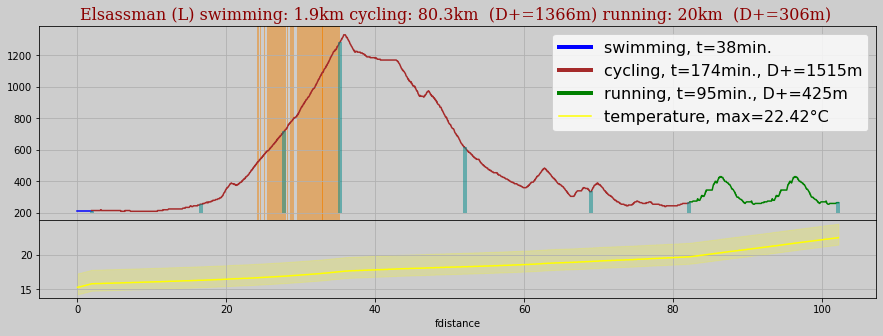

In [7]:
simulation.show_race_details(xaxis="time day")
simulation.show_race_details(xaxis="Time")
simulation.show_race_details(xaxis="fdistance")

In [8]:
dbszehzqhrz

NameError: name 'dbszehzqhrz' is not defined

In [ ]:
simulation.show_roadmap()


In [ ]:
# Dataframe to models
df_model_properties = pd.DataFrame({
    'Model':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all'],    
    'Features': [['t'],['t'],['t'],['t'],['t','h'],
                 ['t','h'],['t','h'],['t','h','T'],
                 ['t','h','T'],['t','h','T','A','W','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H']],
    'Regressors':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all']
}).set_index('Model')

display(df_model_properties)

for f in ['MAE_test', 'R2_test', 'MAE_train', 'R2_train']:
    df_model_properties[f] = ""
    

In [ ]:
# Import Calories Dataset
df_cal = pd.read_csv('kkcalories/calories.csv')

# Import Exercises Dataset
df_ex  = pd.read_csv('kkcalories/exercise.csv')

# Merging Datasets
df = pd.merge(df_ex, df_cal, on = 'User_ID')
df.head()

# Convert string to int
df['Gender'] = pd.get_dummies(df['Gender'], prefix_sep='_', drop_first=True)
df = df.drop(columns=['User_ID'], axis=1)

display(df.head())

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["Calories"]), df["Calories"], test_size=0.3)

In [ ]:
correlations = df.copy().corr()['Calories']
correlations = correlations.sort_values(ascending=False).drop('Calories', axis=0)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=2)

correlations.to_frame().plot.bar(ax=ax[0][0]);
sns.histplot(df['Age'], ax=ax[1][0])
#sns.displot(x='Gender', y='Calories', data=df, ax=ax[0][1]);

sns.jointplot(x='Age', y='Calories', data=df, kind="hex", color="#4CB391")

From here, it is possible to see that the features that most contribute to the total calory burned on exercises is the 'duration', the 'heart rate' and the 'body temperature'

Let's rename the variables as:

t  : Duration
h  : Heart_Rate
T  : Body_Temp
A  : Age
W  : Weight
G  : Gender
H  : Height
C  : Calories

In [ ]:
df_3f = df[['Duration','Heart_Rate','Body_Temp','Calories']].copy()
df_3f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Calories':'C'},inplace=True)


df_6f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Height','Calories']].copy()
df_6f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Height':'H',
                      'Calories':'C'},inplace=True)


df_7f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Gender','Height','Calories']].copy()
df_7f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

sns.pairplot(df_3f)

From the scatter graphics, it's possible to conclude that, despite the strong correlation between the variables  t  and  C , the relation between them is not trivially linear. It's possible that a quadratic regression approach can substantially reduce the errors. Another way to deal with this problem is with power law models. To do this, let's check the relation betweeen logs of variables.

## One Feature Regression

### Linear Model
### Quadratic Model
### Power Law Models
### Model Comparison

As a first step, let's calculate the regression relating Calories and Duration, that are the most correlated variables.

In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task="regression",metric='rmse', time_budget=300)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

regressors = [linear_model.LinearRegression(), 
              RandomForestRegressor(n_estimators=30, random_state=42), 
              DecisionTreeRegressor(random_state=42), XGBRegressor()]

plt.figure(figsize=(10, 5))
plt.scatter(df['Duration'], df['Calories'],c='lightgray',label = 'observations',alpha = 0.6, marker='.',zorder=1)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

for reg in regressors:
    # Create a lineat regression object
    # reg = linear_model.LinearRegression()

    # Train the model using the training sets
    reg.fit(x_train, y_train)

    # Predictions for the test set
    p_test, p_train = reg.predict(x_test), reg.predict(x_train)

    mae_test = mean_absolute_error(y_test, p_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, p_test))
    r2s_test = r2_score(y_test, p_test)
    
    mae_train = mean_absolute_error(y_train, p_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, p_train))
    r2s_train = r2_score(y_train, p_train)
    
    # Printing  results
    print(f'{type(reg)} me (test): {mae_test:.3f}, R2 (test):  {r2s_test:.3f}, RMSE (test):  {rmse_test:.3f}')
    print(f'{type(reg)} me (train): {mae_train:.3f}, R2 (train):  {r2s_train:.3f}, RMSE (train):  {rmse_train:.3f}')

    # Plotting and comparing
    #plt.plot(np.linspace(t_i.min(), t_i.max(), 100), reg.predict(t_val.reshape(-1,1)), c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)

In [ ]:
corr_matrix = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) 
sns.heatmap(corr_matrix, annot=False ,cmap=cmap)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scl = MinMaxScaler(feature_range = (0, 1))
#X = scl.fit_transform(X)
#X

In [ ]:
plt.style.use(['dark_background'])
fig = plt.figure(figsize=(10, 5),facecolor='b', edgecolor='g')
plt.scatter(y_test,p_test ,s=10,c='g',label='Predicted') 
plt.plot(y_test, y_test,'white' ,label='Test' ,linewidth=2.0)
plt.legend(fontsize=20)
plt.show()

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, p_test))  
print('MSE:', metrics.mean_squared_error(y_test, p_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, p_test)))
print('VarScore:',metrics.explained_variance_score(y_test, p_test))

score = reg.score(x_train, y_train)
percentage = "{:.0%}".format(score)

print('Acc_Score:',percentage)

In [ ]:
trianer.hist_calories_per_sport()

In [ ]:
trianer.wordcloud_calories_per_sport()